In [1]:
# !pip install h5py==2.10
# !pip install opencv-python

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd "/content/gdrive/MyDrive/CS601/Assignment 1"

/content/gdrive/MyDrive/CS601/Assignment 1


In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices())
if tf.test.is_built_with_cuda():
    print("CUDA set up for this TensorFlow installation!")
else:
    print("CUDA not ready. Check for CUDA Toolkit and CUDNN version compatibility")

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CUDA set up for this TensorFlow installation!


# Preamble

Import the relevant packages

In [5]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, MaxPool2D, Dropout, Dense, Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseCategoricalCrossentropy

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

import cv2

import pandas as pd
import sys
import numpy as np
import csv
import math
import os

from matplotlib import pyplot as plt

## Key Inputs

Set up experiment related settings:

|Input|Description|
|---|---|
|`use_sample`|Trigger sampling of data to facilitate faster prototyping|
|`sample_probability`|Chance that a row is selected to be a sample|
|`use_datagen`|Trigger for whether to use `ImageDataGenerator`|
|`force_restart`|Trigger for whether to train model from scratch|
|`epochs`|Number of times to train over the dataset|
|`metrics`|Metric classes to be included in the `.compile()` phase|
|`final_layer_activation`|Activation function to use in the last layer|
|`optimizer`|Optimizer for model compilation|
|`loss`|Loss function for model compilation|
|`reduce_lr`|`LRReduceOnPlateau` callback to reduce learning rate after stagnation|
|`directory`|Directory to store checkpoint callback information and model|

In [6]:
use_sample = False
sample_probability = 0.05
use_datagen = False
force_restart = True

epochs = 50
metrics = [SparseCategoricalAccuracy("sparse_categorical_accuracy"), SparseCategoricalCrossentropy(name="sparse_categorical_cross_entropy")]

final_layer_activation = 'softmax'
optimizer = RMSprop(learning_rate=0.001)
loss = 'sparse_categorical_crossentropy'
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=3, min_lr=0.0005)

directory = "cs601_mobilenetv2_saved"

if not os.path.exists(directory):
    os.makedirs(directory)
    print("Directory created at [{}]!".format(directory))
else:
    "Directory [{}] exists!"

## Import Dataset

In [7]:
# Class names for different classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

# Load training data, labels; and testing data and their true labels
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

if use_sample:
    mask = np.random.choice([False, True], len(train_images), p=[1 - sample_probability, sample_probability])
    train_images, train_labels = train_images[mask], train_labels[mask]

# Normalize pixel values between -1 and 1
train_images = train_images / 127.5 - 1 
test_images = test_images / 127.5 - 1 

print ('Training data size:', train_images.shape, 'Test data size', test_images.shape)

Training data size: (50000, 32, 32, 3) Test data size (10000, 32, 32, 3)


## Visualize dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

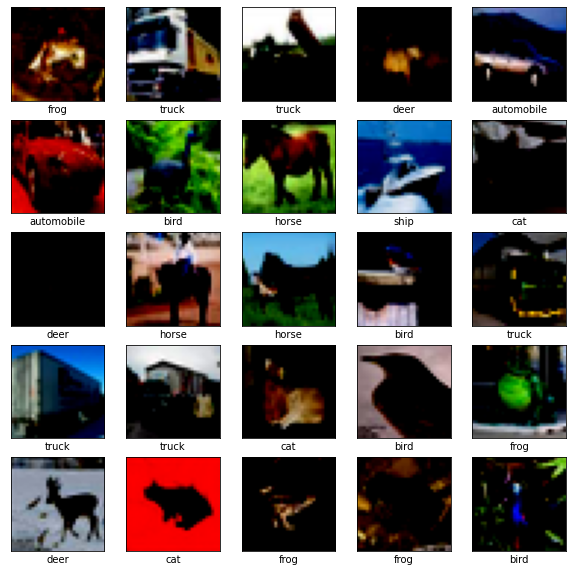

In [8]:
%matplotlib inline
#Show first 25 training images below
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])

## Resize images for use with MobileNetV2

In [9]:
# Upsize all training and testing images to 96x96 for use with mobile net
minSize = 96 #minimum size requried for mobileNetV2
input_shape=(minSize,minSize,3)
class_num = len(class_names)
image_num_train = len(train_images)
image_num_test = len(test_images)

# You may use cv2 package. Look for function:
resized_train_images = np.zeros((image_num_train, minSize, minSize, 3), dtype=np.float32)

resized_test_images = np.zeros((image_num_test, minSize, minSize, 3), dtype=np.float32)

for index, image in enumerate(train_images):
    resized_train_images[index]=cv2.resize(image, dsize=(minSize, minSize), interpolation=cv2.INTER_AREA)

for index, image in enumerate(test_images):
    cv2.resize(i, dsize=(minSize, minSize), interpolation=cv2.INTER_AREA)
    resized_test_images[index]=cv2.resize(image, dsize=(minSize, minSize), interpolation=cv2.INTER_AREA)

In [10]:
def make_model():
    """Create new MobileNetV2 model with frozen layers
    """
    # Initiate MobileNetV2 and freeze layers
    base_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=input_shape)
    base_model.trainable=False

    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(filters=16, kernel_size=(5, 5),strides=(2,2), padding='same',activation='relu'))
    model.add(Conv2D(filters=16, kernel_size=(5, 5),strides=(2,2), padding='same',activation='relu'))
    model.add(MaxPool2D(pool_size=(4, 4),strides=(2,2), padding='same'))
    model.add(Dropout(0.1))
    model.add(Conv2D(filters=32, kernel_size=(4, 4), padding='same',activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=(4, 4), padding='same',activation='relu'))
    model.add(MaxPool2D(pool_size=(3, 3), padding='same'))
    model.add(Dropout(0.1))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same',activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same',activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Flatten())
    model.add(Dense(class_num, activation=final_layer_activation))
    return model

In [11]:
if force_restart:
    print("Force restart enabled")
    model = make_model()
    print("Created new model!")
else:
    try:
        print("Loading existing model from [{}]".format(directory))
        model = tf.keras.models.load_model(directory)
        print("Loaded model successfully!")
    except:
        model = make_model()
        print("Created new model!")

Force restart enabled
Created new model!


In [12]:
len(resized_train_images)

50000

# Add loss function, compile and train the model, and check accuracy on test data

In [13]:
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 16)          512016    
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 16)          6416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 32)          8224      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 32)          1

In [14]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(directory,"checkpoints"),monitor="val_loss")    
history = model.fit(
    x=resized_train_images,
    y=train_labels,
    epochs=epochs,
    callbacks=[reduce_lr,model_checkpoint_callback])

Epoch 1/50
1563/1563 [==============================] - 122s 76ms/step - loss: 1.4577 - sparse_categorical_accuracy: 0.4273 - sparse_categorical_cross_entropy: 1.4577
INFO:tensorflow:Assets written to: cs601_mobilenetv2_saved/checkpoints/assets
Epoch 2/50
1563/1563 [==============================] - 115s 73ms/step - loss: 0.8207 - sparse_categorical_accuracy: 0.7390 - sparse_categorical_cross_entropy: 0.8207
INFO:tensorflow:Assets written to: cs601_mobilenetv2_saved/checkpoints/assets
Epoch 3/50
1563/1563 [==============================] - 117s 75ms/step - loss: 0.6683 - sparse_categorical_accuracy: 0.7889 - sparse_categorical_cross_entropy: 0.6683
INFO:tensorflow:Assets written to: cs601_mobilenetv2_saved/checkpoints/assets
Epoch 4/50
1563/1563 [==============================] - 106s 68ms/step - loss: 0.5803 - sparse_categorical_accuracy: 0.8214 - sparse_categorical_cross_entropy: 0.5803
INFO:tensorflow:Assets written to: cs601_mobilenetv2_saved/checkpoints/assets
Epoch 5/50
1563/1563

In [15]:
predicted = np.argmax(model.predict(resized_test_images),axis=1)

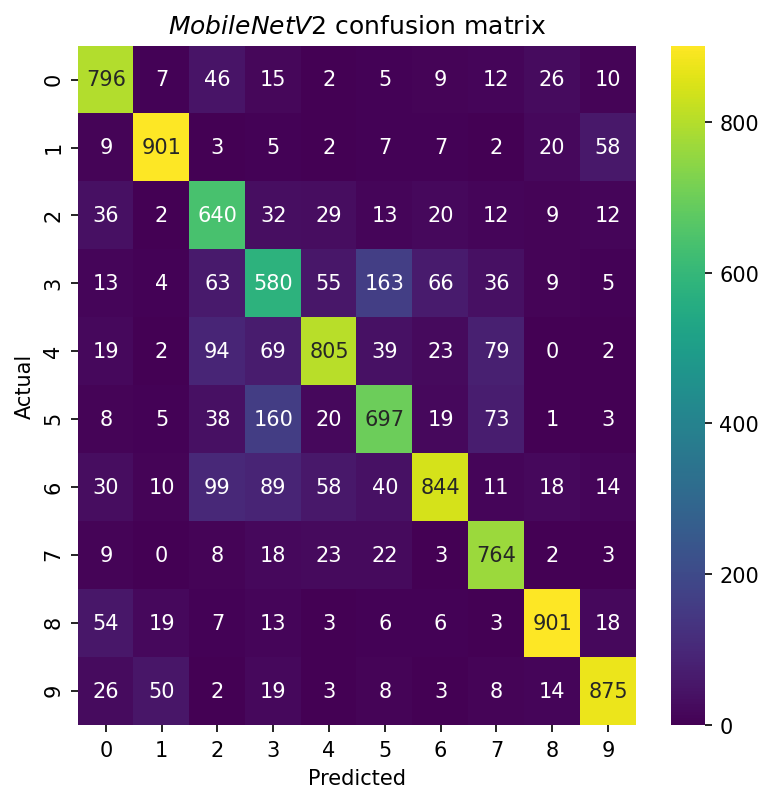

In [16]:
cm = confusion_matrix(predicted,test_labels)
plt.figure(dpi=150,figsize=(6,6))
plt.title("$MobileNetV2$ confusion matrix")
sns.heatmap(cm,cmap="viridis",annot=True,fmt=".0f")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("confusion_matrix.jpeg")

In [17]:
loss, accuracy, cross_entropy = model.evaluate(resized_test_images,test_labels)

313/313 [==============================] - 18s 55ms/step - loss: 4.8026 - sparse_categorical_accuracy: 0.7803 - sparse_categorical_cross_entropy: 4.8026


In [18]:
str_length = 35
left_column = "".join([r"{:<",str(str_length),"}"])
print("".join([left_column," [{:.2f}]"]).format("The loss metric is",loss))
print("".join([left_column," [{:.2f}]"]).format("The accuracy is",accuracy))
print("".join([left_column," [{:.2f}]"]).format("The categorical cross entropy is",cross_entropy))

The loss metric is                  [4.80]
The accuracy is                     [0.78]
The categorical cross entropy is    [4.80]


In [19]:
model.save(directory,save_format='tf')

INFO:tensorflow:Assets written to: cs601_mobilenetv2_saved/assets


# Extra code for producing different plots

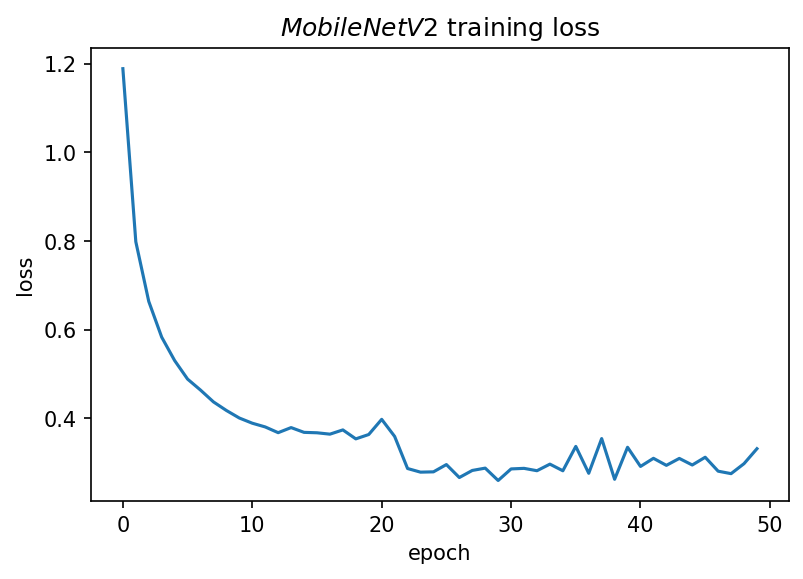

In [20]:
# summarize history for loss
plt.figure(dpi=150)
plt.plot(history.history['loss'])
plt.title('$MobileNetV2$ training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.savefig("history_loss.jpeg")
plt.show()

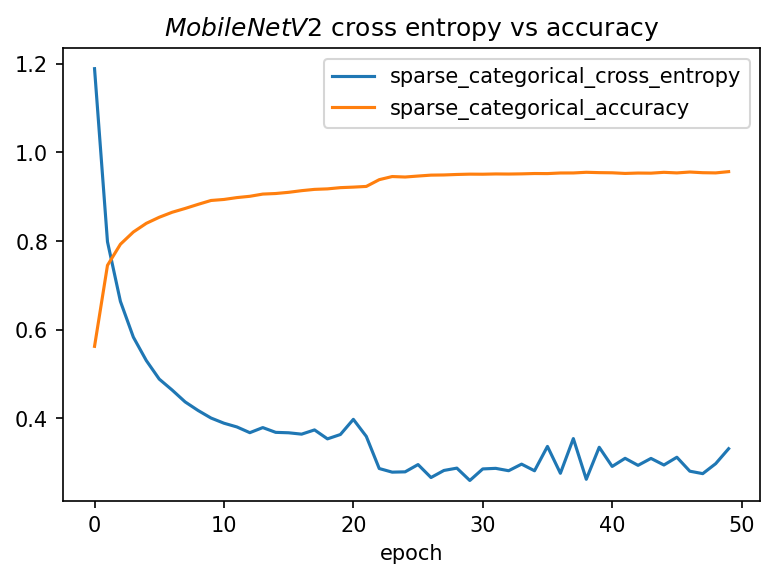

In [21]:
# summarize history for sparse_categorical_cross_entropy
import pandas as pd
plt.figure(dpi=150)
plot_data = pd.DataFrame({'sparse_categorical_cross_entropy':history.history['sparse_categorical_cross_entropy'],'sparse_categorical_accuracy':history.history['sparse_categorical_accuracy']})
plt.plot(plot_data)
plt.title('$MobileNetV2$ cross entropy vs accuracy')
plt.xlabel('epoch')
plt.legend(plot_data.columns.to_list())
plt.savefig("history_cross_entropy_accuracy.jpeg")
plt.show()

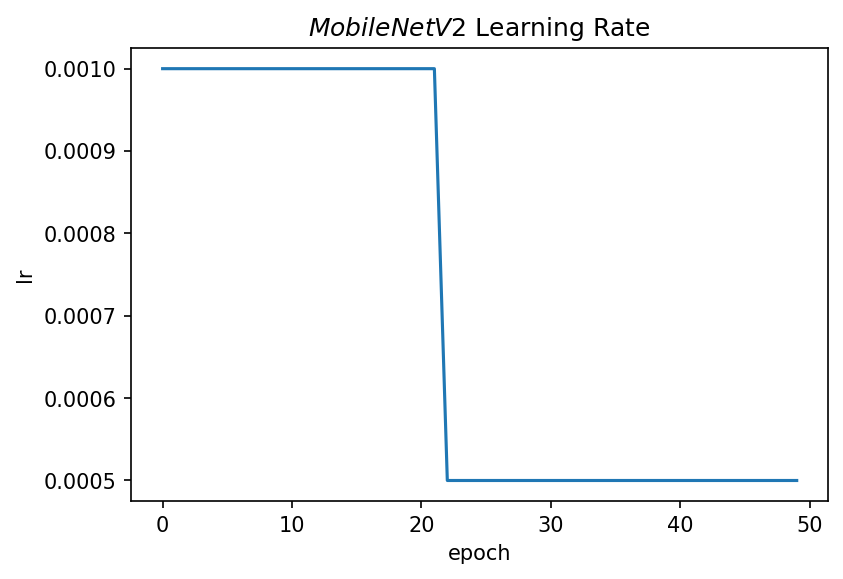

In [22]:
# summarize history for sparse_categorical_cross_entropy
plt.figure(dpi=150)
plt.plot(history.history['lr'])
plt.title('$MobileNetV2$ Learning Rate')
plt.ylabel('lr')
plt.xlabel('epoch')
plt.savefig("history_lr.jpeg")
plt.show()

# Model persistence
The following code loads a previously saved model from directory and evaluates it

In [23]:
model = tf.keras.models.load_model(directory)

In [24]:
str_length = 35
left_column = "".join([r"{:<",str(str_length),"}"])
print("".join([left_column," [{:.2f}]"]).format("The loss metric is",loss))
print("".join([left_column," [{:.2f}]"]).format("The accuracy is",accuracy))
print("".join([left_column," [{:.2f}]"]).format("The categorical cross entropy is",cross_entropy))

The loss metric is                  [4.80]
The accuracy is                     [0.78]
The categorical cross entropy is    [4.80]


In [26]:
restored_predict = np.argmax(model.predict(resized_test_images),axis=1)
accuracy_score(test_labels,predicted)

0.7803

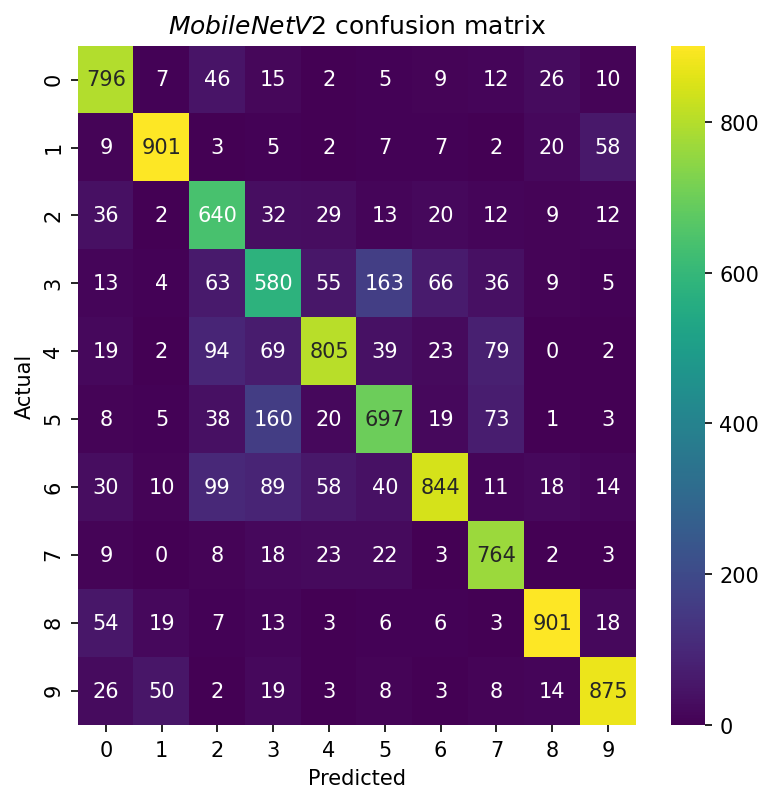

In [27]:
cm = confusion_matrix(restored_predict,test_labels)
plt.figure(dpi=150,figsize=(6,6))
plt.title("$MobileNetV2$ confusion matrix")
sns.heatmap(cm,cmap="viridis",annot=True,fmt=".0f")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("confusion_matrix.jpeg")

In [ ]:
# reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,patience=3, min_lr=min_lr)
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(directory,"checkpoints"),monitor="val_loss")
# if use_datagen:
#     print("Using ImageDataGen!")
#     datagen.fit(resized_train_images)
#     history = model.fit(
#         datagen.flow(resized_train_images,train_labels,batch_size=32),
#         steps_per_epoch=image_num_train,
#         epochs=epochs,
#         callbacks=[reduce_lr,model_checkpoint_callback])
# else:
#     history = model.fit(
#         x=resized_train_images,
#         y=train_labels,
#         epochs=epochs,
#         callbacks=[reduce_lr,model_checkpoint_callback])

In [ ]:
# datagen = ImageDataGenerator(
#     rotation_range=10, 
#     width_shift_range=0.1,
#     height_shift_range=0.1, 
#     shear_range=0.1, 
#     zoom_range=0.2,
#     fill_mode='nearest', 
#     horizontal_flip=True, 
#     vertical_flip=True    
# )